In [126]:
from igraph import *

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import math
import requests
import pickle
import json
import copy
import os
import re

from sklearn.preprocessing import scale
import warnings
warnings.filterwarnings('ignore')

In [48]:
sdg_data = pd.read_excel('SDR-2022-database.xlsx')
sdg_data.head()

,Country Code ISO3,Country,Year,Population,Region,Income Group,SDG Index Score,Goal 1 Score,Goal 2 Score,Goal 3 Score,...,n_sdg16_cpi,n_sdg16_clabor,n_sdg16_weaponsexp,n_sdg16_rsf,n_sdg16_justice,n_sdg17_govex,n_sdg17_oda,n_sdg17_govrev,n_sdg17_cohaven,n_sdg17_statperf
0,AFG,Afghanistan,2000,20779957.0,E_Euro_Asia,LIC,44.819087,91.417142,33.883143,20.329857,...,0.0,45.573,100.0,61.329,42.308,26.327,NaN,0.0,100.0,16.297
1,AFG,Afghanistan,2001,21606992.0,E_Euro_Asia,LIC,45.109257,91.417142,36.932429,20.445929,...,0.0,45.573,100.0,61.329,42.308,26.327,NaN,0.0,100.0,16.297
2,AFG,Afghanistan,2002,22600774.0,E_Euro_Asia,LIC,45.032270,91.417142,35.922000,20.720143,...,0.0,45.573,100.0,61.329,42.308,26.327,NaN,0.0,100.0,16.297
3,AFG,Afghanistan,2003,23680871.0,E_Euro_Asia,LIC,45.275423,91.417142,37.142571,20.932000,...,0.0,45.573,100.0,61.329,42.308,26.327,NaN,0.0,100.0,16.297
4,AFG,Afghanistan,2004,24726689.0,E_Euro_Asia,LIC,45.530799,91.417142,37.827429,21.980500,...,0.0,45.573,100.0,61.329,42.308,26.327,NaN,0.0,100.0,16.297


In [152]:
sdg_pearson = sdg_data.corr(method='spearman')
sdg_pearson.head()

,Year,Population,SDG Index Score,Goal 1 Score,Goal 2 Score,Goal 3 Score,Goal 4 Score,Goal 5 Score,Goal 6 Score,Goal 7 Score,...,n_sdg16_cpi,n_sdg16_clabor,n_sdg16_weaponsexp,n_sdg16_rsf,n_sdg16_justice,n_sdg17_govex,n_sdg17_oda,n_sdg17_govrev,n_sdg17_cohaven,n_sdg17_statperf
Year,1.000000,0.061640,0.204393,0.058592,0.102548,0.189401,0.140355,0.238550,0.099985,0.158795,...,0.011164,-0.001064,0.000185,-0.050174,0.079664,0.097142,0.101404,0.059655,0.000000,0.088577
Population,0.061640,1.000000,-0.049078,-0.099321,0.105419,-0.101143,-0.072282,-0.021933,0.005919,-0.131301,...,-0.259598,-0.105844,-0.264660,-0.302611,-0.320684,-0.156671,0.128658,-0.309653,0.101530,0.164097
SDG Index Score,0.204393,-0.049078,1.000000,0.871042,0.720038,0.922064,0.870385,0.712747,0.890043,0.787718,...,0.694886,0.877675,-0.512373,0.465263,0.749861,0.708724,0.419352,0.527184,-0.439265,0.800855
Goal 1 Score,0.058592,-0.099321,0.871042,1.000000,0.589384,0.860027,0.769408,0.508714,0.784141,0.653013,...,0.602771,0.862904,-0.433096,0.375614,0.669599,0.597721,0.254650,0.474140,-0.429842,0.631094
Goal 2 Score,0.102548,0.105419,0.720038,0.589384,1.000000,0.689013,0.650794,0.529198,0.654706,0.520094,...,0.608270,0.632056,-0.514421,0.323546,0.567306,0.458691,0.016581,0.188255,-0.433713,0.667711


In [153]:
sdg_goals = {}
sdg_temp = []
for item in sdg_pearson:
    if item.startswith('Goal '):
        sdg_goals[item] = []
        sdg_temp.append(item)
    if item.startswith('n_sdg'):
        n_sdg = item[5:7]
        goal_number = re.sub('[^0-9]', '', n_sdg)
        sdg_goals[f'Goal {goal_number} Score'].append(item)
'''
for item in sdg_goals:
    print(item)
    for sub_item in sdg_goals[item]:
        print(sub_item)
'''
sdg_goals_list = list(sdg_goals.keys())

In [154]:
sdg_pearson = sdg_pearson[list(sdg_goals.keys())]
sdg_pearson = sdg_pearson.loc[list(sdg_goals.keys())]
sdg_pearson.head()

,Goal 1 Score,Goal 2 Score,Goal 3 Score,Goal 4 Score,Goal 5 Score,Goal 6 Score,Goal 7 Score,Goal 8 Score,Goal 9 Score,Goal 10 Score,Goal 11 Score,Goal 12 Score,Goal 13 Score,Goal 14 Score,Goal 15 Score,Goal 16 Score,Goal 17 Score
Goal 1 Score,1.000000,0.589384,0.860027,0.769408,0.508714,0.784141,0.653013,0.625565,0.737472,0.588366,0.728804,-0.825105,-0.815142,-0.287564,0.089683,0.732804,0.439135
Goal 2 Score,0.589384,1.000000,0.689013,0.650794,0.529198,0.654706,0.520094,0.632505,0.707533,0.312944,0.534724,-0.585013,-0.590445,-0.180944,0.144008,0.616787,0.297539
Goal 3 Score,0.860027,0.689013,1.000000,0.856975,0.624573,0.827901,0.751791,0.715353,0.849054,0.462498,0.791840,-0.856704,-0.825482,-0.247247,0.095476,0.809979,0.471779
Goal 4 Score,0.769408,0.650794,0.856975,1.000000,0.693679,0.775845,0.662740,0.706825,0.765581,0.364268,0.733520,-0.797970,-0.756993,-0.237091,0.084187,0.682238,0.428573
Goal 5 Score,0.508714,0.529198,0.624573,0.693679,1.000000,0.655210,0.542171,0.610578,0.630659,0.113856,0.648370,-0.600417,-0.545027,-0.026094,0.208533,0.488657,0.463690


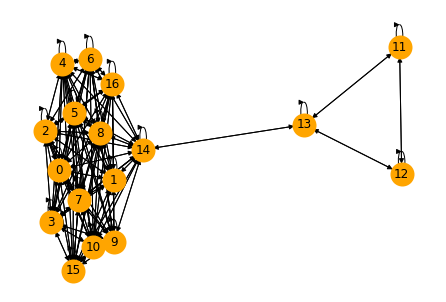

In [161]:
sdg_goals_names = list(sdg_goals.keys())
values = sdg_pearson.values
graph = Graph.Adjacency((values>0).tolist())
#graph.es['weight'] = values[values.nonzero()]
#graph.vs['label'] = sdg_goals_names
graph = graph.to_networkx()

nx.draw(graph, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=4, font_size=12, pos=nx.spring_layout(graph, k=0.15, weight='value', iterations=50))

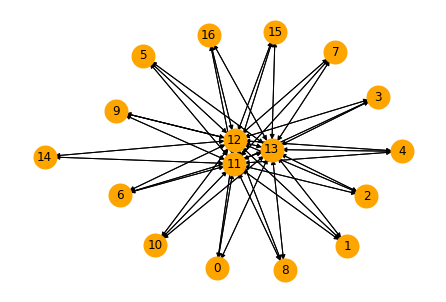

In [155]:
sdg_goals_names = list(sdg_goals.keys())
values = sdg_pearson.values
graph = Graph.Adjacency((values<0).tolist())
#graph.es['weight'] = values[values.nonzero()]
#graph.vs['label'] = sdg_goals_names
graph = graph.to_networkx()

nx.draw(graph, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=4, font_size=12, pos=nx.spring_layout(graph, k=0.15, weight='value', iterations=50))

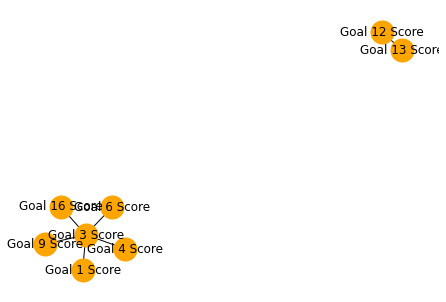

In [164]:
target_1 = sdg_goals_list[5]
target_2 = sdg_goals_list[15]
edges = sdg_pearson.stack().reset_index()
edges.columns = [target_1, target_2, 'value']
edges_filtered=edges.loc[ (edges['value'] > 0.8) & (edges[target_1] != edges[target_2]) ]
G=nx.from_pandas_edgelist(edges_filtered, target_1, target_2)
nx.draw(G, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=4, font_size=12, pos=nx.spring_layout(G, k=0.15, weight='value', iterations=50))

In [157]:
political_blogs = Graph.Read(
    f="polblogs.gml", format="gml"
    )
political_blogs_data = f'{political_blogs.summary()[7:].replace("-","").strip()[:-51]} {len(political_blogs.clusters(mode="strong"))} {len(political_blogs.clusters(mode="weak"))} {political_blogs.maxdegree()} {political_blogs.average_path_length()} {political_blogs.diameter()} {political_blogs.transitivity_avglocal_undirected()} {political_blogs.transitivity_undirected()}'
political_blogs_data = political_blogs_data.split()
data_requests = ['type', 'n', 'm', 'c_strong', 'c_weak', 'd', 'l', 'L', 'cc_l', 'cc_g']
counter = 0
for data in political_blogs_data:
    print(f'{data_requests[counter]}: {data}')
    counter += 1

type: D
n: 1490
m: 19090
c_strong: 688
c_weak: 268
d: 468
l: 3.3901837252152363
L: 9
cc_l: 0.3600286522101197
cc_g: 0.2259585173589758


N = 1490, mean +- sd: 25.6242 +- 42.9418
Each * represents 4 items
[  0,   1): ****************************************************************** (266)
[  1,   2): ******************************** (129)
[  2,   3): *********************** (95)
[  3,   4): ******************** (80)
[  4,   5): ************* (53)
[  5,   6): ********** (40)
[  6,   7): ********** (41)
[  7,   8): ******** (34)
[  8,   9): ******* (29)
[  9,  10): **** (16)
[ 10,  11): ***** (21)
[ 11,  12): ***** (21)
[ 12,  13): *** (14)
[ 13,  14): ***** (22)
[ 14,  15): ****** (25)
[ 15,  16): ******* (28)
[ 16,  17): **** (16)
[ 17,  18): ***** (23)
[ 18,  19): ***** (20)
[ 19,  20): **** (16)
[ 20,  21): *** (13)
[ 21,  22): **** (16)
[ 22,  23): **** (16)
[ 23,  24): ** (11)
[ 24,  25): ** (8)
[ 25,  26): * (7)
[ 26,  27): ** (8)
[ 27,  28): *** (12)
[ 28,  29): ** (8)
[ 29,  30): * (5)
[ 30,  31): ** (10)
[ 31,  32): * (6)
[ 32,  33): * (7)
[ 33,  34): *** (12)
[ 34,  35): ** (10)
[ 35,  36): * (7)
[ 36,  37): ** 

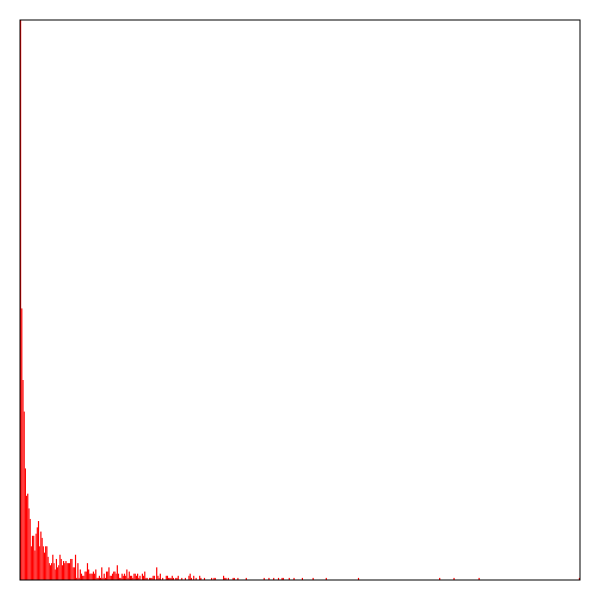

In [158]:
print(political_blogs.degree_distribution())
plot(political_blogs.degree_distribution())

N = 981248, mean +- sd: 3.3902 +- 1.1302
Each * represents 5901 items
[ 1,  2): *** (19022)
[ 2,  3): ******************************** (193830)
[ 3,  4): *********************************************************** (348198)
[ 4,  5): ********************************************** (275702)
[ 5,  6): ****************** (107394)
[ 6,  7): **** (25602)
[ 7,  8): * (10092)
[ 8,  9):  (1371)
[ 9, 10):  (37)


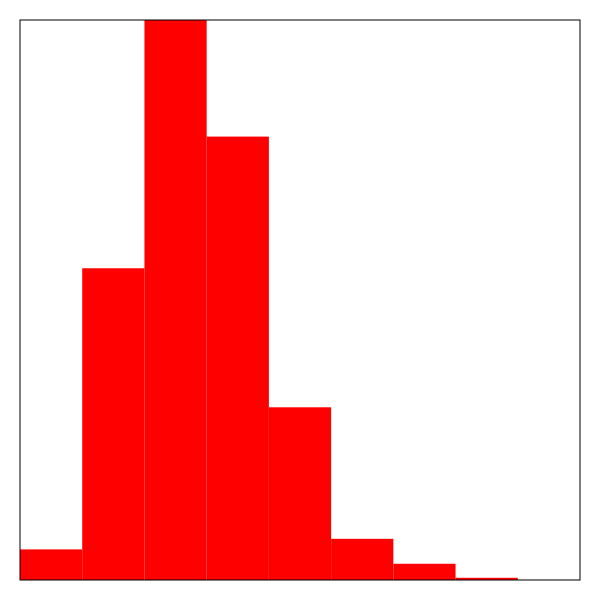

In [159]:
print(political_blogs.path_length_hist())
plot(political_blogs.path_length_hist())